In [1]:
### Goals -- generate activity that reflects null dynamics + noise and null dynamics 
### make a 1D potent space; 
### make "commands"
### look at distance from cond-spec to command pooled (match pool to cond-spec)
### sample from pool to make shuffles 

In [36]:
def get_activity(dim = 30, nconds=10, cond_com=1000): 
    '''
    method to generate activity according to null dynamics + null offset and zero dynamics + null offset
    inputs: 
        dim: dimensionality of data. last dimension is potent space 
        nconds: number of conditions to analyze
        cond_com: number of commands / condition 
    '''
    cond = np.zeros((nconds*cond_com, )) 
    noise1 = np.random.randn(dim, nconds*cond_com)
    noise2 = np.random.randn(dim, nconds*cond_com)
    for nc in range(nconds): cond[nc*cond_com:(nc+1)*cond_com] = nc; 
    assert(len(np.nonzero(cond == 0)[0]) == cond_com)
    
    ### null offset 
    offset_full = np.random.randn(dim)
    offset_null = offset_full.copy()
    offset_null[-1] = 0.
    
    ## null dynamics : identity in null space, zero in potent space (last dimension)
    dyn_eye = np.eye(dim - 1)
    dyn = np.vstack(( np.hstack((dyn_eye, np.zeros((dim -1, 1)))), np.zeros((1, dim))))
    
    ## no dynamics 
    dyn0 = np.zeros_like(dyn)
    
    ## activity = Ax_t + b + noise 
    activity_null_do = np.dot(dyn, noise1) + offset_null[:, np.newaxis] + noise2
    activity_null_o = np.dot(dyn0, noise1) + offset_null[:, np.newaxis] + noise2
    
    ## full activity 
    dyn_full = np.eye(dim)
    activity_full_do = np.dot(dyn_full, noise1) + offset_full[:, np.newaxis] + noise2
    activity_full_o = np.dot(dyn0, noise1) + offset_full[:, np.newaxis] + noise2
    
    
    return activity_null_do, activity_null_o, activity_full_do, activity_full_o, cond

In [2]:
def get_command_ids(pot_activity): 
    '''
    get out command ids based on percentiles 
    acceptable command ids to analyze are indices 1, 2, 3, 4
    '''
    command_boundaries = np.array([np.percentile(pot_activity, 5), 
                                   np.percentile(pot_activity, 27.5),
                                   np.percentile(pot_activity, 50.),
                                   np.percentile(pot_activity, 72.5),
                                   np.percentile(pot_activity, 95)])
    
    # returned index `i` satisfies \`bins[i-1] <= x < bins[i]``
    command_id = np.digitize(pot_activity, command_boundaries, right=False)
    
    return command_id

In [40]:
def get_cond_com_pls_matched_inds(commands, condition, activity, nshuff=100): 
    '''
    
    '''
    assert(len(commands) == len(condition) == activity.shape[1])
    
    cc_dist = {}
    shuff_cc_dist = {} 
    
    for com in [1, 2, 3, 4]: 
        for cond in range(10): 
            
            ## command-condition 
            ix_cc = np.nonzero(np.logical_and(commands == com, condition == cond))[0]
            
            ## Find condition pool that matches this 
            ix_com = np.nonzero(commands == com)[0]
            
            ## Return indices that match 
            ix_com = match_ix(ix_cc, ix_com, activity[-1, :])
            
            if ix_com is not None: 
                
                #print('Command %d Cond %d, ix_cc N=%d, ix_com N=%d'%(com, cond, len(ix_cc), len(ix_com)))
                
                shuff_cc_dist[com, cond] = []
                
                # Global pool
                pool_mn = np.mean(activity[:, ix_com], axis=1)

                # Shuffle_dist
                for i_shuff in range(nshuff): 
                    
                    ## which indices 
                    ix_ = np.random.permutation(len(ix_com))[:len(ix_cc)]
                    mn_ = np.mean(activity[:, ix_com[ix_]], axis=1)
                    shuff_cc_dist[com,cond].append(np.linalg.norm(pool_mn - mn_))
                
                cc_dist[com, cond] = np.linalg.norm(pool_mn - np.mean(activity[:, ix_cc], axis=1))
    return cc_dist, shuff_cc_dist

In [41]:
def match_ix(ix0, ix1, val): 
    ix1_keep = np.arange(len(ix1))
    _, p = scipy.stats.ttest_ind(val[ix0], val[ix1[ix1_keep]])
    
    mn0 = np.mean(val[ix0])
    st0 = np.std(val[ix0])
    
    while p < .4: 
        #print('    ix1kp=%d'%len(ix1_keep))
        cost = np.abs((val[ix1[ix1_keep]] - mn0)/st0)
        
        # Drop last 5%: 
        N = len(ix1_keep)
        keep_N = int(np.round(.95*N))
        ix1_keep = np.argsort(cost)[:keep_N]
        ix1_keep = np.sort(ix1_keep)
    
        _, p = scipy.stats.ttest_ind(val[ix0], val[ix1[ix1_keep]])
        
        if len(ix1_keep) <= len(ix0): 
            break
    if p >= .4:
        return ix1[ix1_keep]
    else:
        return None
        
    
    

In [42]:
def plot(cc_dist, shuff_cc_dist, title): 
    f, ax = plt.subplots()
    for i_k, k in enumerate(cc_dist.keys()): 
        ax.plot(i_k, cc_dist[k], 'k.')

        mn_shuff = np.mean(shuff_cc_dist[k])
        st_shuff = np.std(shuff_cc_dist[k])
        ax.plot([i_k, i_k], [mn_shuff - 2*st_shuff, mn_shuff+2*st_shuff], 'b-', alpha=.5)
    ax.set_title(title)

In [43]:
def plot2(cc_dist, shuff_cc_dist, x, ax = None): 
    norm = []
    if ax is None: 
        f, ax = plt.subplots()
    for i_k, k in enumerate(cc_dist.keys()): 
        mn_ = cc_dist[k]
        mn_shuff = np.mean(shuff_cc_dist[k])
        norm.append(mn_/mn_shuff)
    ax.bar(x, np.mean(norm))
    ax.errorbar(x, np.mean(norm), np.std(norm), marker='|', color='k')
    return ax
    

In [45]:
### Get activity 
a_null_do, a_null_o, a_full_do, a_full_o, cond = get_activity()

(0.8, 1.2)

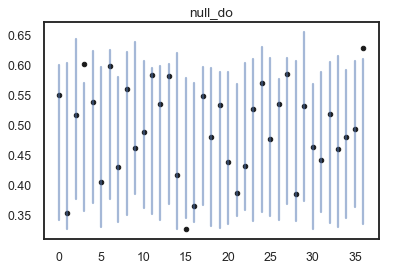

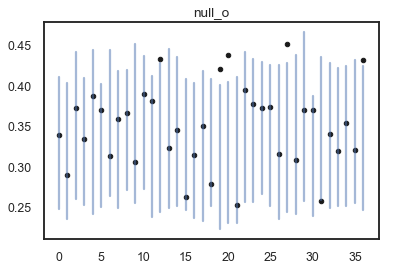

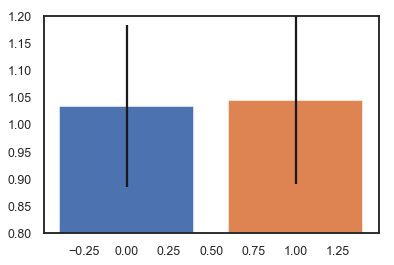

In [46]:
############### NULL ################
#####################################
### Get commands -- analyze: 1, 2, 3, 4 (0 and 5 are out of bounds)
commands_do = get_command_ids(a_null_do[-1, :])
commands_o = get_command_ids(a_null_o[-1, :])

assert(np.all(commands_o == commands_do))

### For each condition / command, compare to pool
cc_dist_do, shuff_cc_dist_do = get_cond_com_pls_matched_inds(commands_do, cond, a_null_do)
cc_dist_o, shuff_cc_dist_o = get_cond_com_pls_matched_inds(commands_o, cond, a_null_o)

plot(cc_dist_do, shuff_cc_dist_do, 'null_do')
plot(cc_dist_o, shuff_cc_dist_o, 'null_o')

ax = plot2(cc_dist_do, shuff_cc_dist_do, 0, None)
ax = plot2(cc_dist_o, shuff_cc_dist_o, 1, ax)
ax.set_ylim([.8, 1.2])

(0.8, 1.2)

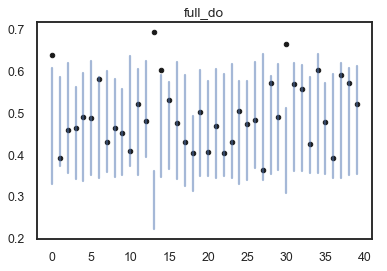

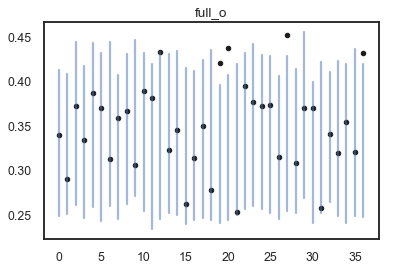

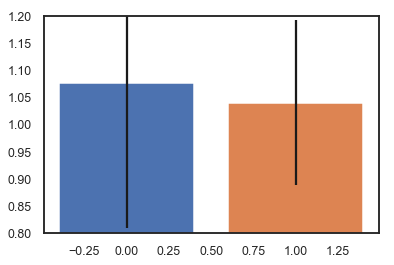

In [48]:
############### FULL ################
#####################################
### Get commands -- analyze: 1, 2, 3, 4 (0 and 5 are out of bounds)
commands_do = get_command_ids(a_full_do[-1, :])
commands_o = get_command_ids(a_full_o[-1, :])

### For each condition / command, compare to pool
cc_dist_do, shuff_cc_dist_do = get_cond_com_pls_matched_inds(commands_do, cond, a_full_do)
cc_dist_o, shuff_cc_dist_o = get_cond_com_pls_matched_inds(commands_o, cond, a_full_o)

plot(cc_dist_do, shuff_cc_dist_do, 'full_do')
plot(cc_dist_o, shuff_cc_dist_o, 'full_o')

ax = plot2(cc_dist_do, shuff_cc_dist_do, 0, None)
ax = plot2(cc_dist_o, shuff_cc_dist_o, 1, ax)
ax.set_ylim([.8, 1.2])

In [18]:
pdb

Automatic pdb calling has been turned ON


In [23]:
%matplotlib notebook